# Import libs

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
import scipy.io
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

# Choose figure

In [5]:
file_name  = 'data/inpainting/inpainting.mat'

mat = scipy.io.loadmat(file_name)
img_np = mat["image"].astype(np.float32)
img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(dtype)
mask_np = mat["mask"].astype(np.float32)
mask_np = np.expand_dims(mask_np,2)
mask_np = mask_np.transpose(2,0,1)
mask_var = torch.from_numpy(mask_np).type(dtype)

# ensure dimensions [0][1] are divisible by 32 (or 2^depth)!

### Visualize

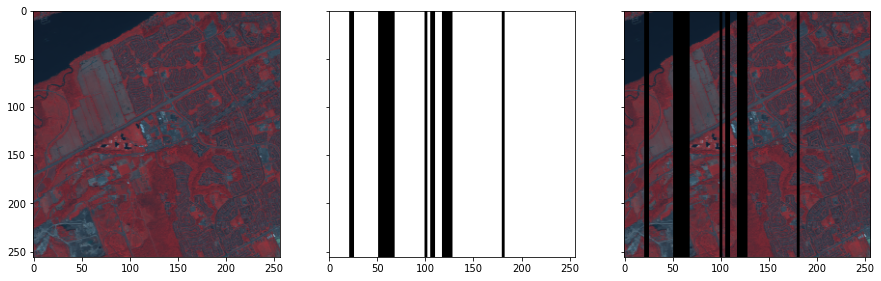

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(torch.stack((img_var[56,:,:].cpu(),img_var[26,:,:].cpu(),img_var[16,:,:].cpu()),2))
ax2.imshow(mask_var.permute(1,2,0).cpu().squeeze(), cmap='gray') 
ax3.imshow(torch.stack(((img_var[56,:,:]*mask_var[0,:,:]).cpu(),(img_var[26,:,:]*mask_var[0,:,:]).cpu(),(img_var[16,:,:]*mask_var[0,:,:]).cpu()),2))
plt.show()

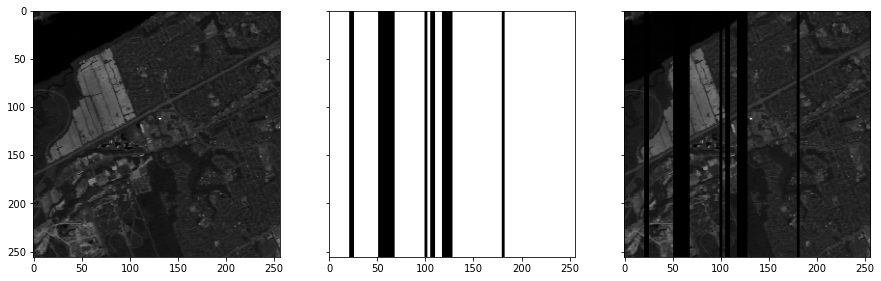

In [3]:
# band to visualize
band = 150

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(img_var[band,:,:].cpu(), cmap='gray')
ax2.imshow(mask_var.permute(1,2,0).cpu().squeeze(), cmap='gray') 
ax3.imshow((img_var*mask_var)[band,:,:].cpu(), cmap='gray')
plt.show()

# Setup

In [4]:
pad = 'reflection' #'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

method = '2D'
input_depth = img_np.shape[0] 
LR = 0.01  
num_iter = 10001
param_noise = False
reg_noise_std = 0.1 # 0 0.01 0.03 0.05

show_every = 1000
save_every = 1000

net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [128] * 5, 
           num_channels_up =   [128] * 5,
           num_channels_skip =    [128] * 5,  
           filter_size_up = 3, filter_size_down = 3, 
           upsample_mode='nearest', filter_skip_size=1,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

'''
# UNet

reg_noise_std = 0.02
LR = 0.001

net = UNet(num_input_channels=input_depth, num_output_channels=img_np.shape[0], 
           feature_scale=8, more_layers=1, 
           concat_x=False, upsample_mode='deconv', 
           pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
'''


'''
#ResNet

reg_noise_std = 0.02
LR = 0.001
net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')

LR = 0.001
param_noise = False
'''        

net = net.type(dtype)
net_input = get_noise(input_depth, method, img_np.shape[1:]).type(dtype)

In [5]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_var = img_var[None, :].cuda()
mask_var = mask_var[None, :].cuda()

Number of params: 3203628


# Main loop

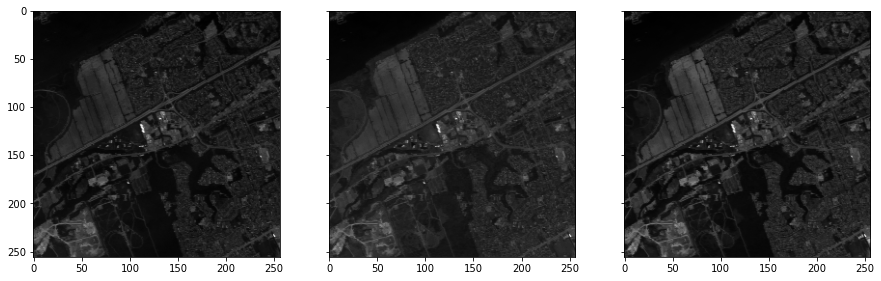

Starting optimization with ADAM


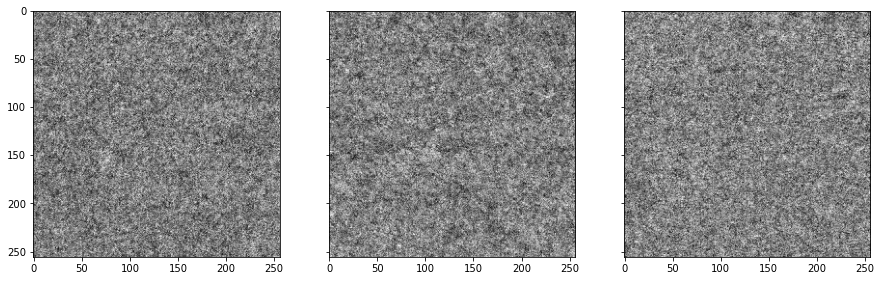

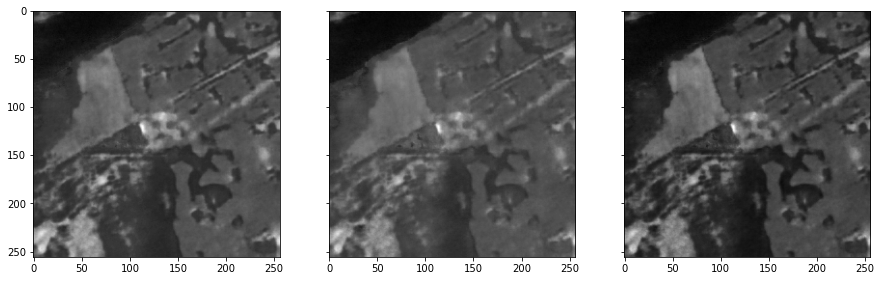

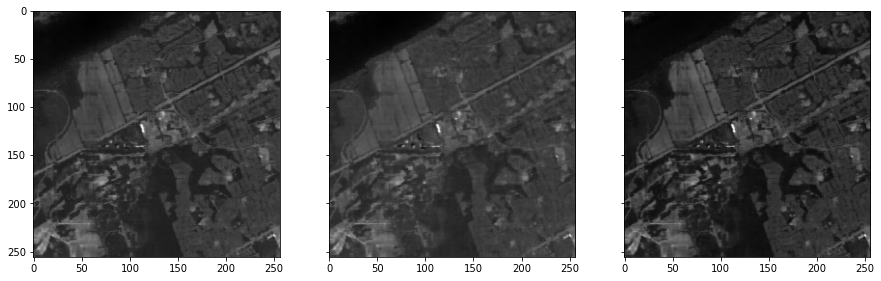

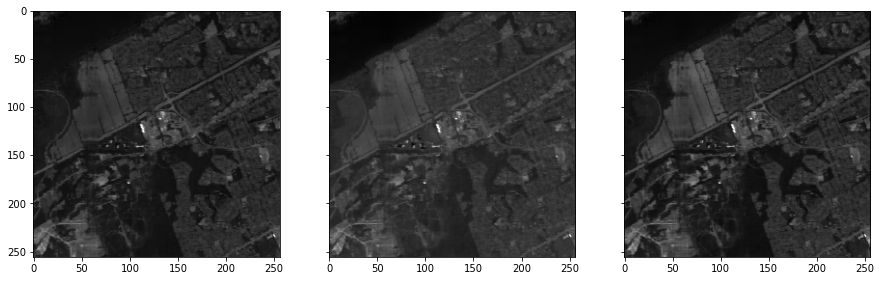

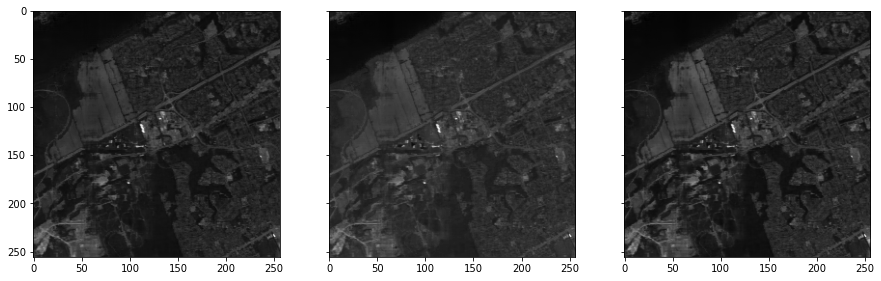

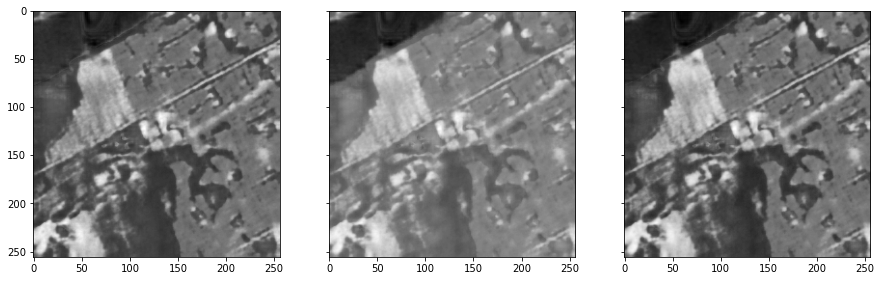

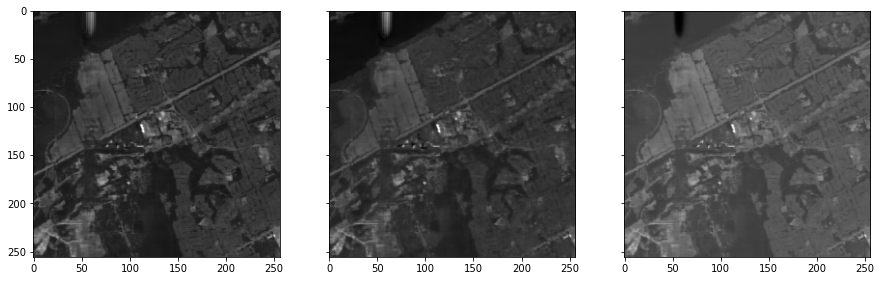

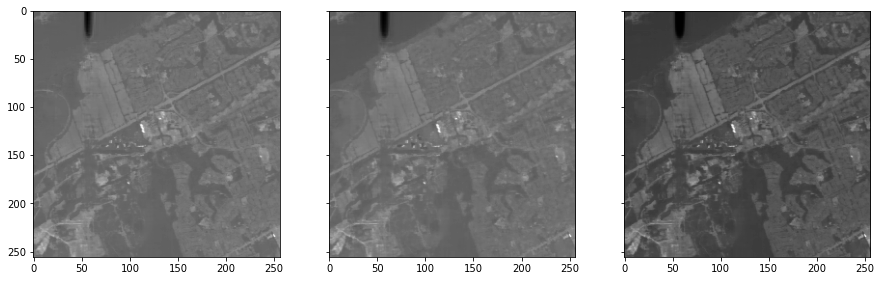

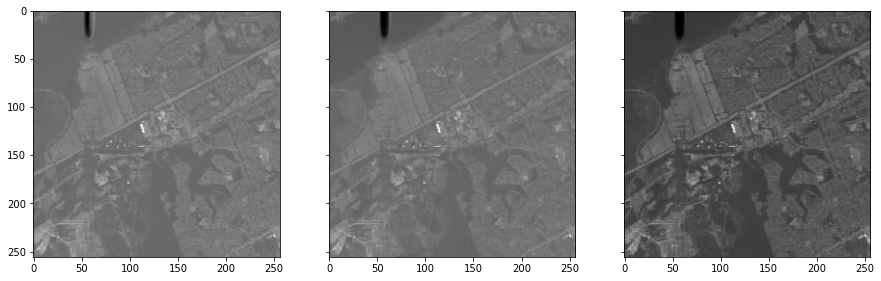

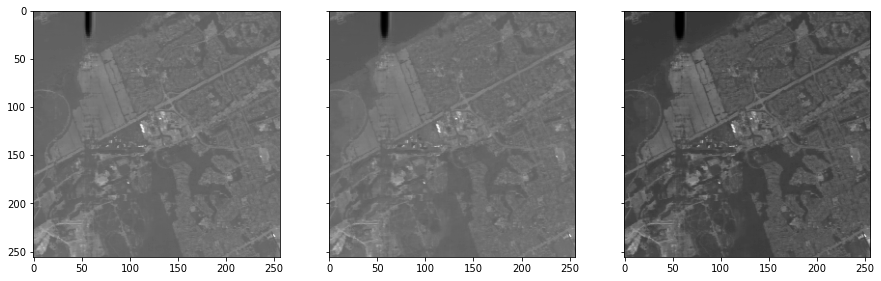

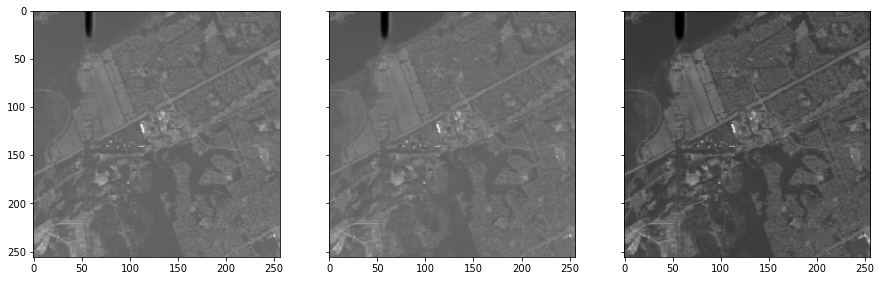

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
ax1.imshow(img_var.detach().cpu().numpy()[0,2,:,:], cmap='gray')
ax2.imshow(img_var.detach().cpu().numpy()[0,8,:,:], cmap='gray')
ax3.imshow(img_var.detach().cpu().numpy()[0,18,:,:], cmap='gray')
plt.show()
        
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
         
    out = net(net_input)
    
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
        
        
    # print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  i % show_every == 0:
        out_np = out.detach().cpu().numpy()[0]
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))
        ax1.imshow(out_np[2,:,:], cmap='gray')
        ax2.imshow(out_np[8,:,:], cmap='gray')
        ax3.imshow(out_np[18,:,:], cmap='gray')
        plt.show()
        psrn_masked = peak_signal_noise_ratio(img_np* mask_np, out.detach().cpu().numpy()[0] * mask_np) 
        psrn = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
        print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')
        
    if  i % save_every == 0:
        out_np = out.detach().cpu().squeeze().numpy()
        scipy.io.savemat("results/result_inpainting_2D_it%d.mat" % (i), {'pred':out_np.transpose(1,2,0)})
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

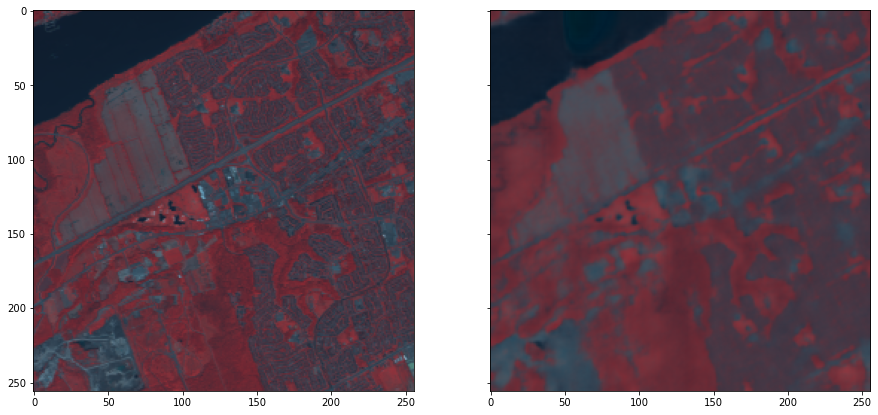

In [7]:
# load result
file_name = "results/result_inpainting_2D_it5000.mat"
mat = scipy.io.loadmat(file_name)
result_np = mat["pred"]
result_np = result_np.transpose(2,0,1)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
ax1.imshow(np.stack((img_np[56,:,:],img_np[26,:,:],img_np[16,:,:]),2))
ax2.imshow(np.stack((result_np[56,:,:],result_np[26,:,:],result_np[16,:,:]),2))
plt.show()

# result_var = torch.from_numpy(result_np).type(dtype)
# f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True, figsize=(15,15))
# ax1.imshow(img_var.detach().cpu().numpy()[0,2,:,:], cmap='gray')
# ax2.imshow(img_var.detach().cpu().numpy()[0,8,:,:], cmap='gray')
# ax3.imshow(img_var.detach().cpu().numpy()[0,18,:,:], cmap='gray')

# ax4.imshow(result_var.detach().cpu().numpy()[2,:,:], cmap='gray')
# ax5.imshow(result_var.detach().cpu().numpy()[8,:,:], cmap='gray')
# ax6.imshow(result_var.detach().cpu().numpy()[18,:,:], cmap='gray')
# plt.show()
